
Classificador
1. Importar dados

Para criar um classificador formatar os dados da sequinte maneira:

moleculas -> uma lista/array com todos os smiles do seu banco de dados

classes -> uma lista/array de zeros e uns representando antibiótico e não antibiótico, respectivamente

O classificador vai identificar traços das moleculas e associá-los às classes, então cada molécula deverá ter o mesmo índice que sua classe.

bibliotecas sugeridas:

    pandas
    numpy



In [66]:
import pandas as pd
import numpy as np
import sklearn as sk

#Importar dados
df = pd.read_csv('/home/joao/documentos/IC-Joao/classificador/final_data_betalac.csv',index_col=False)

#Definir a coluna das classes
labels = np.asarray(df.Classe) #1 para antibiótico, 0 para não antibiótico

#Selecionar SMILES sem as classes
df_selected = df.drop(["Classe","Name","Index"], axis=1)

#Codificar classes (não é mais necessário)
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#le.fit(labels)

#labels = le.transform(labels)


2. Processamento dos dados
2.1 Encoding/padding

Nessa etapa acontece a codificação das moleculas. Pode ser tokens, one hot vector, integer vector. Você decide.

É importante que ao final do processamento todos os tokens tenham o mesmo comprimento, então um processo chamado padding precisa ser aplicado.

Por convenção as variáveis em machine learning assumem esses nomes:

X -> uma lista/array com todos os smiles codificados

y -> uma lista/array de zeros e uns representando antibiótico e não antibiótico, respectivamente

Bibliotecas sugeridas:

    numpy
    sklearn



ADIÇÕES DO TIAGO: INICIO

In [67]:
comprimentos = [len(x) for x in df_selected.SMILES.values]

In [68]:
maior_smile = np.max(comprimentos)
maior_smile

394

In [69]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

smiles = list(df_selected.SMILES.values)

table = ['se','Fe','As','Cl', 'Br', 'Na', 'Li', 'Ca', 'Al', 'Ag', 'Se', 'Mg', 'Zn', 'H', 'B', 'C', 'N', 'O', 'P', 'S', 'F', 'I', 'K', '(', ')', '[', ']', '=', '#', '@', '*', '%', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.', '/', '\\', '+', '-', 'c', 'n', 'o', 's', 'p']


In [70]:
len(smiles)

4480

In [71]:
smiles[6]

'CC1C(C(=O)N1S(=O)(=O)O)NC(=O)C(=NOC(C)(C)C(=O)O)C2=CSC(=N2)N'

In [72]:
def tokenizer(smiles,table):
    tokens_list = []
    #index = 0
    for smile in smiles:
        #print(index)
        i = 0
        token = []
        while i < len(smile):
            for j in table:
                if j == smile[i:i+len(j)]:
                    token.append(j)
                    i = i+len(j)
                    break
        while len(token) < maior_smile:
            token.insert(0,"A")
        tokens_list.append(token)
        #index = index+1
    return tokens_list

padded_tokens = tokenizer(smiles,table)


In [73]:
len(padded_tokens)

4480

In [74]:
len(padded_tokens[0])

394

In [75]:
#Usar integer encoding ao invez de one hot
from sklearn.preprocessing import LabelEncoder
tokens_encoder = LabelEncoder()
table.append("A")
tokens_encoder.fit(table)
tokens_int_encoded = np.array([tokens_encoder.transform(i) for i in padded_tokens])


In [76]:
tokens_int_encoded

array([[21, 21, 21, ..., 39,  3, 27],
       [21, 21, 21, ..., 39,  3, 27],
       [21, 21, 21, ..., 39,  3, 37],
       ...,
       [21, 21, 21, ...,  3, 27, 27],
       [21, 21, 21, ..., 27,  3, 27],
       [21, 21, 21, ..., 27,  3, 27]])

In [77]:
tokens_int_encoded.shape

(4480, 394)

ADIÇÕES DO TIAGO: FIM


3. Holdout: train/test split

Depois do processamento, seu banco de dados precisa ser dividio em traino e teste. O Holdout é o ponto de separação. Geralmente os dados são dividos em dados em 70/30. 70% para treino e 30% para teste.

Agora as variáveis serão separadas pelos conjuntos criados:

X_treino -> 70% dos smiles codificados

X_teste -> 30% dos smiles codificados

y_treino -> 70% das classes

y_teste -> 30% das classes

Bibliotecas sugeridas:

    numpy
    sklearn



In [78]:
from sklearn.model_selection import train_test_split

smiles_train, smiles_test, labels_train, labels_test = train_test_split(
    tokens_int_encoded, labels, 
    test_size=0.30, random_state=42)



4. Modelo

Depois de preparar os dados, precisamos criar um variável que contem nosso modelo. Estude o tensoflow/keras, mais especificamente a função Sequential(), para criação dos modelos.

Arquiteturas sugeridas:

    MultiLayer Perceptron (MLP)
    Convolutional Neural Networks (CNN)

Não esqueça de adicionar as métricas precision, recall, accuracy e loss. Para essa ultima, você precisa estudar sobre as funções de perda usadas para classificação binária (0,1).

Depois de construído use o método .fit() para treinar seu classificador


In [79]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
model = Sequential([
    tf.keras.layers.Input(shape = 394,),
    tf.keras.layers.Dense(350, activation = 'relu'),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model.compile(
    optimizer='adam',
    loss = tf.losses.BinaryCrossentropy(),
    metrics = [tf.metrics.BinaryAccuracy(),
    tf.metrics.Precision(),
    tf.metrics.Recall()]

)

In [80]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 350)               138250    
                                                                 
 dense_8 (Dense)             (None, 200)               70200     
                                                                 
 dense_9 (Dense)             (None, 100)               20100     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 228,651
Trainable params: 228,651
Non-trainable params: 0
_________________________________________________________________


In [81]:
labels_test

array([0, 0, 0, ..., 0, 0, 1])

In [82]:
MLP = model.fit(smiles_train,labels_train, epochs=100, verbose =1,validation_data=(smiles_test,labels_test))

Epoch 1/100
98/98 [==============================] - 1s 3ms/step - loss: 0.3750 - binary_accuracy: 0.9652 - precision_2: 0.0500 - recall_2: 0.0274 - val_loss: 0.1086 - val_binary_accuracy: 0.9732 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/100
98/98 [==============================] - 0s 1ms/step - loss: 0.1809 - binary_accuracy: 0.9767 - precision_2: 0.5000 - recall_2: 0.0411 - val_loss: 0.1220 - val_binary_accuracy: 0.9732 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0783 - binary_accuracy: 0.9793 - precision_2: 1.0000 - recall_2: 0.1096 - val_loss: 0.0880 - val_binary_accuracy: 0.9740 - val_precision_2: 1.0000 - val_recall_2: 0.0278
Epoch 4/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0613 - binary_accuracy: 0.9834 - precision_2: 0.8621 - recall_2: 0.3425 - val_loss: 0.1336 - val_binary_accuracy: 0.9732 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e

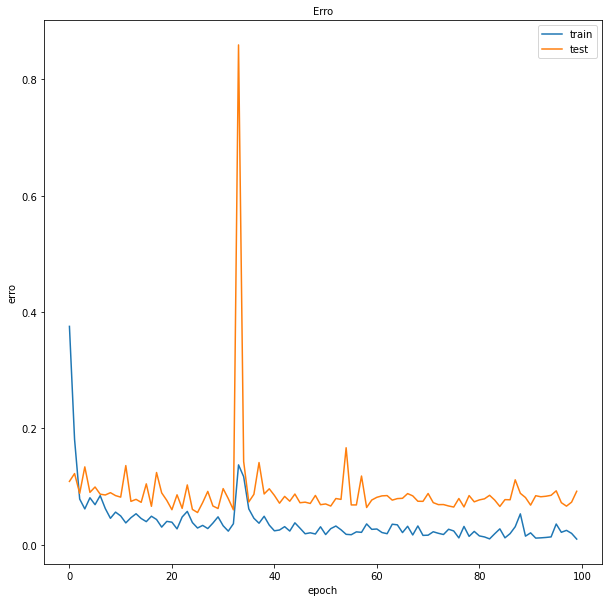

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(MLP.history['loss'],label = 'train')
plt.plot(MLP.history['val_loss'],label = 'test')
plt.title('Erro', fontsize =10)
plt.xlabel('epoch')
plt.ylabel('erro')
plt.legend()


In [84]:
predictions = np.round(model.predict(smiles_test))

In [85]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predictions)

In [86]:
import seaborn as sns


Text(0.5, 15.0, 'PREDICTED')

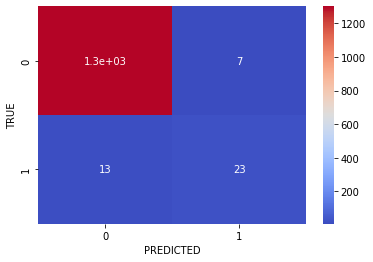

In [87]:
sns.heatmap(cm, annot=True,cmap='coolwarm')
plt.ylabel("TRUE")
plt.xlabel("PREDICTED")

In [88]:
tn, fp, fn, tp = confusion_matrix(labels_test, predictions).ravel()

In [89]:
tn, fp, fn, tp 

(1301, 7, 13, 23)

In [90]:
#acurácia
(tp+tn)/(tp+tn+fp+fn)

0.9851190476190477

In [91]:
#acerta o que é antibiótico
(tp)/(tp+fn)

0.6388888888888888

In [92]:
#acerta o que não é antibiótico
(tn)/(tn+fp)

0.9946483180428135

Convolucional

In [93]:
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout

In [94]:
CNN = Sequential([
    tf.keras.layers.Embedding(input_dim = 394, output_dim = 1, input_length = maior_smile),

    tf.keras.layers.Conv1D(filters = 32,kernel_size = 3),  #Conv1
    tf.keras.layers.MaxPooling1D(pool_size = 3), 

    #tf.keras.layers.Conv1D(filters = 64,kernel_size = 3),  #Conv2

    tf.keras.layers.Conv1D(filters = 128,kernel_size = 3), #Conv3
    tf.keras.layers.MaxPooling1D(pool_size = 3),

    #tf.keras.layers.Conv1D(filters = 256,kernel_size = 3), #Conv4
    

    tf.keras.layers.Conv1D(filters = 256,kernel_size = 3), #Conv5
    tf.keras.layers.MaxPooling1D(pool_size = 3),

    tf.keras.layers.Conv1D(filters = 256,kernel_size = 3),    #Conv6
    tf.keras.layers.MaxPooling1D(pool_size = 3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.42),
    
    tf.keras.layers.Dense(394, activation = "relu"),
    tf.keras.layers.Dense(150, activation = "relu"),

    tf.keras.layers.Dense(1, activation = "sigmoid")
])
CNN.compile(
    optimizer = tf.optimizers.Adam(),
    loss = tf.losses.BinaryCrossentropy(),
    metrics = [
        tf.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)


In [95]:
trainer = CNN.fit(
     smiles_train,
     labels_train,
     epochs = 100,
     batch_size = 10,
     validation_data = (smiles_test,labels_test),  
     verbose = 1)

Epoch 1/100
314/314 [==============================] - 2s 6ms/step - loss: 0.1442 - binary_accuracy: 0.9761 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.1240 - val_binary_accuracy: 0.9732 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/100
314/314 [==============================] - 2s 5ms/step - loss: 0.1203 - binary_accuracy: 0.9767 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.1122 - val_binary_accuracy: 0.9732 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/100
314/314 [==============================] - 1s 5ms/step - loss: 0.0944 - binary_accuracy: 0.9783 - precision_3: 0.6667 - recall_3: 0.1370 - val_loss: 0.1067 - val_binary_accuracy: 0.9829 - val_precision_3: 0.9333 - val_recall_3: 0.3889
Epoch 4/100
314/314 [==============================] - 2s 5ms/step - loss: 0.0863 - binary_accuracy: 0.9834 - precision_3: 0.7838 - recall_3: 0.3973 - val_loss: 0.0885 - val_binary_accuracy: 0.9821 - val_precision_3: 0.8333 - v

In [96]:
y_hat = (CNN.predict(smiles_test) > 0.5).astype("float")

In [97]:
cm2 = confusion_matrix(labels_test, y_hat)  

Text(0.5, 33.0, 'Predicted Values')

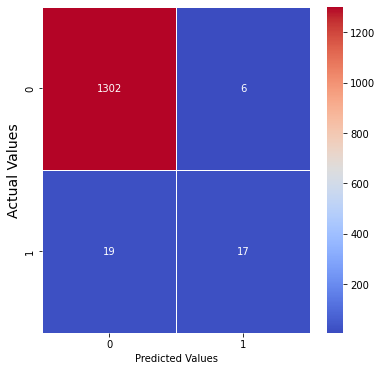

In [98]:
plt.figure(figsize = (6,6))
sns.heatmap(cm2, annot = True, fmt = ".5g", cmap = "coolwarm",linewidths=.5)
plt.ylabel('Actual Values',fontsize = 14)
plt.xlabel('Predicted Values')


In [99]:
tn2, fp2, fn2, tp2 = confusion_matrix(labels_test, y_hat).ravel()
tn2, fp2, fn2, tp2

(1302, 6, 19, 17)

In [100]:
#acurácia
(tp2+tn2)/(tp2+tn2+fp2+fn2)

0.9813988095238095

In [101]:
#acerta o que é antibiótico
(tp2)/(tp2+fn2)

0.4722222222222222

In [102]:
#acerta o que não é antibiótico
(tn2)/(tn2+fp2)

0.9954128440366973

Convolucional mais simples

In [103]:
CNN2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = 53,output_dim = 1,input_length = maior_smile),
    tf.keras.layers.Conv1D(filters = 16,kernel_size = 3),
    tf.keras.layers.MaxPooling1D(pool_size = 5),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Conv1D(filters = 32,kernel_size = 3),
    tf.keras.layers.MaxPooling1D(pool_size = 4),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Conv1D(filters = 64,kernel_size = 3),
    tf.keras.layers.MaxPooling1D(pool_size = 2),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Conv1D(filters = 128,kernel_size = 3),
    tf.keras.layers.MaxPooling1D(pool_size = 2),   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.42),

    tf.keras.layers.Dense(394, activation = "relu"),
    tf.keras.layers.Dense(150, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
    ])
CNN2.compile(
    optimizer = tf.optimizers.Adam(),
    loss = tf.losses.BinaryCrossentropy(),
    metrics = [
        tf.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

In [104]:
trainer = CNN2.fit(
     smiles_train,
     labels_train,
     batch_size = 10,
     epochs = 100,
     validation_data = (smiles_test,labels_test),  
     verbose = 1)

Epoch 1/100
314/314 [==============================] - 2s 4ms/step - loss: 0.1318 - binary_accuracy: 0.9767 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 0.2073 - val_binary_accuracy: 0.9732 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/100
314/314 [==============================] - 1s 3ms/step - loss: 0.1241 - binary_accuracy: 0.9767 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 0.1634 - val_binary_accuracy: 0.9732 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/100
314/314 [==============================] - 1s 3ms/step - loss: 0.1087 - binary_accuracy: 0.9767 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 0.0925 - val_binary_accuracy: 0.9732 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 4/100
314/314 [==============================] - 1s 3ms/step - loss: 0.0745 - binary_accuracy: 0.9790 - precision_4: 1.0000 - recall_4: 0.0959 - val_loss: 0.0626 - val_binary_accuracy: 0.9881 - val_precisi

In [105]:
y_hat2 = (CNN2.predict(smiles_test) > 0.5).astype("float")

In [106]:
cm3 = confusion_matrix(labels_test, y_hat2)  

Text(0.5, 33.0, 'Predicted Values')

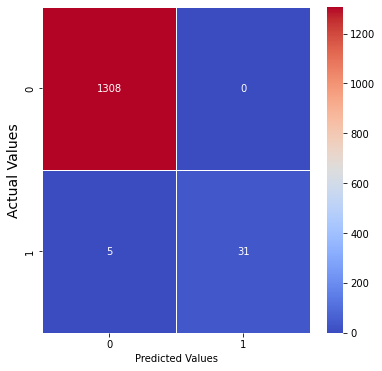

In [107]:
plt.figure(figsize = (6,6))
sns.heatmap(cm3, annot = True, fmt = ".5g", cmap = "coolwarm",linewidths=.5)
plt.ylabel('Actual Values',fontsize = 14)
plt.xlabel('Predicted Values')

In [108]:
tn3, fp3, fn3, tp3 = confusion_matrix(labels_test, y_hat2).ravel()
tn3, fp3, fn3, tp3

(1308, 0, 5, 31)

In [109]:
#acurácia
(tp3+tn3)/(tp3+tn3+fp3+fn3)

0.9962797619047619

In [110]:
#acerta o que é antibiótico
(tp3)/(tp3+fn3)

0.8611111111111112

In [111]:
#acerta o que não é antibiótico
(tn3)/(tn3+fp3)

1.0